# Purchase Time Series Preparation

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Prepare Sample Data

* Find specific merchants, create training, testing

In [2]:
ts_purchase_df = pd.read_pickle('ts_purchase.pkl')
print(ts_purchase_df.shape, ts_purchase_df['merchant'].nunique())

ts_purchase_df.head()

(5568, 4) 49


,merchant,purchase_date,purchase_amount,client_count
0,49th Parallel Grocery,2019-02-11,58743.49,470
1,49th Parallel Grocery,2019-02-12,73984.82,686
2,49th Parallel Grocery,2019-02-13,95749.55,876
3,49th Parallel Grocery,2019-02-14,118723.62,1095
4,49th Parallel Grocery,2019-02-15,152350.76,1379


In [6]:
agg_df = ts_purchase_df[['merchant', 'purchase_date']].astype('str').drop_duplicates()\
          .groupby(['merchant'], as_index=False)['purchase_date']\
          .agg(['count']).reset_index()\
          .sort_values(['count'], ascending=False)

print(min(agg_df['count']), max(agg_df['count']))
agg_df.head()

110 114


,merchant,count
0,49th Parallel Grocery,114
21,Lalumière Bonanza,114
23,Le Marché Esposito,114
1,Asian Food Centre,114
25,Lococo's,114


Yeah, I assigned the purchase dates in uniformal distribution. This mean choose whatever merchant here is similar.

In [36]:
sample_ts_df = ts_purchase_df.loc[ts_purchase_df['merchant']=='49th Parallel Grocery']
print(sample_ts_df.shape)

sample_ts_df.head()

(114, 4)


,merchant,purchase_date,purchase_amount,client_count
0,49th Parallel Grocery,2019-02-11,58743.49,470
1,49th Parallel Grocery,2019-02-12,73984.82,686
2,49th Parallel Grocery,2019-02-13,95749.55,876
3,49th Parallel Grocery,2019-02-14,118723.62,1095
4,49th Parallel Grocery,2019-02-15,152350.76,1379


In [37]:
import warnings
warnings.filterwarnings("ignore")

sample_ts_df['purchase_date'] = sample_ts_df['purchase_date'].astype('datetime64[ns]')

print(sample_ts_df.dtypes)
sample_ts_df.head()

merchant                   object
purchase_date      datetime64[ns]
purchase_amount           float64
client_count                int64
dtype: object


,merchant,purchase_date,purchase_amount,client_count
0,49th Parallel Grocery,2019-02-11,58743.49,470
1,49th Parallel Grocery,2019-02-12,73984.82,686
2,49th Parallel Grocery,2019-02-13,95749.55,876
3,49th Parallel Grocery,2019-02-14,118723.62,1095
4,49th Parallel Grocery,2019-02-15,152350.76,1379


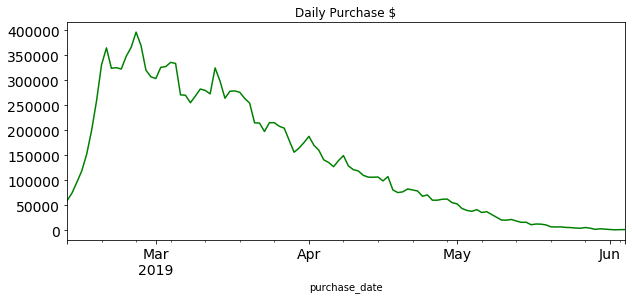

In [40]:
# Plotting data
sample_ts_df.index = sample_ts_df['purchase_date']
sample_ts_df['purchase_amount'].plot(figsize=(10,4), title= 'Daily Purchase $', fontsize=14, color='green')
plt.show()

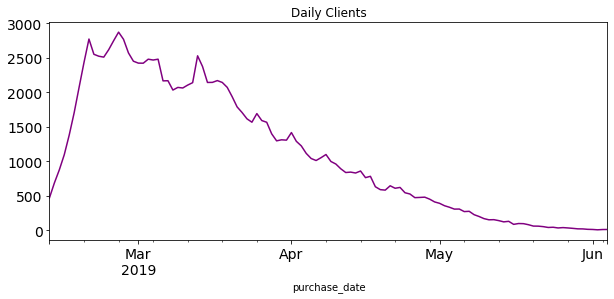

In [41]:
sample_ts_df['client_count'].plot(figsize=(10, 4), title= 'Daily Clients', fontsize=14, color='purple')
plt.show()

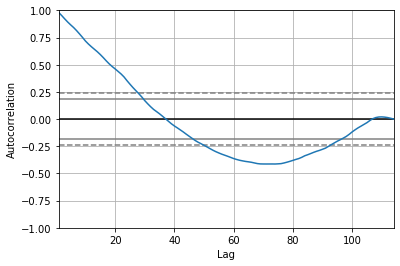

In [42]:
# Autocorrelation plot
autocorrelation_plot(sample_ts_df['purchase_amount'])
plt.show()

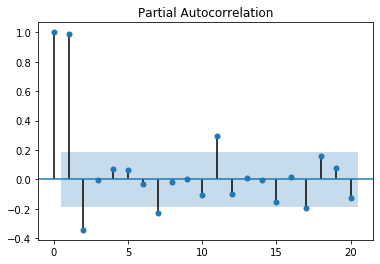

In [57]:
plot_pacf(sample_ts_df['purchase_amount'], lags=20);

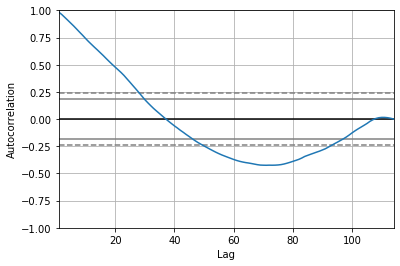

In [43]:
autocorrelation_plot(sample_ts_df['client_count'])
plt.show()

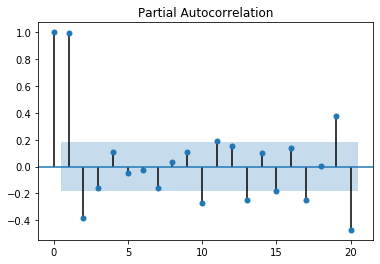

In [58]:
plot_pacf(sample_ts_df['client_count'], lags=20);

### Notes
* In the data, the pattern of client_count and purchase_amount are almost the same.
* The autocorrelation plot (ACF)
  * It summarizes the relationship between an observation in a time series with observations at prior time steps. The relationship here include direct and indirect correlations.
  * From above plots, it's exponential, decaying to 0, so it can be AR (Autoregressive) model
* The partial autocorrelation (PACF)
  * It is similar to autocorrelation plot, but removes those indirect correlations.
* We can start with `AR(2)` or `AR(3)`, since it's showing the first 2,3 lags have strong correlations.

In [47]:
sample_ts_df.drop(['merchant', 'purchase_date'], inplace=True, axis=1)

In [61]:
sample_train_df = sample_ts_df.iloc[0:100, :]
sample_test_df = sample_ts_df.iloc[100:, :]

print(sample_train_df.shape, sample_test_df.shape)
sample_train_df.head()

(100, 2) (14, 2)


,purchase_amount,client_count
purchase_date,,
2019-02-11,58743.49,470
2019-02-12,73984.82,686
2019-02-13,95749.55,876
2019-02-14,118723.62,1095
2019-02-15,152350.76,1379


## Method 1 - Seasonal Decomposing Forecasting

* The methods used here is to forecast residuals after removing the Season and the Trend.
* With this method, we don't need to add season or trend back for forecasting.
* There are additive and multiplicative decomposing 2 methods.
  * Additive Method: `Y[t] = T[t] + S[t] + e[t]`
  * Miltiplicative Method: `Y[t] = T[t] * S[t] * e[t]`

### Additive Decomposing

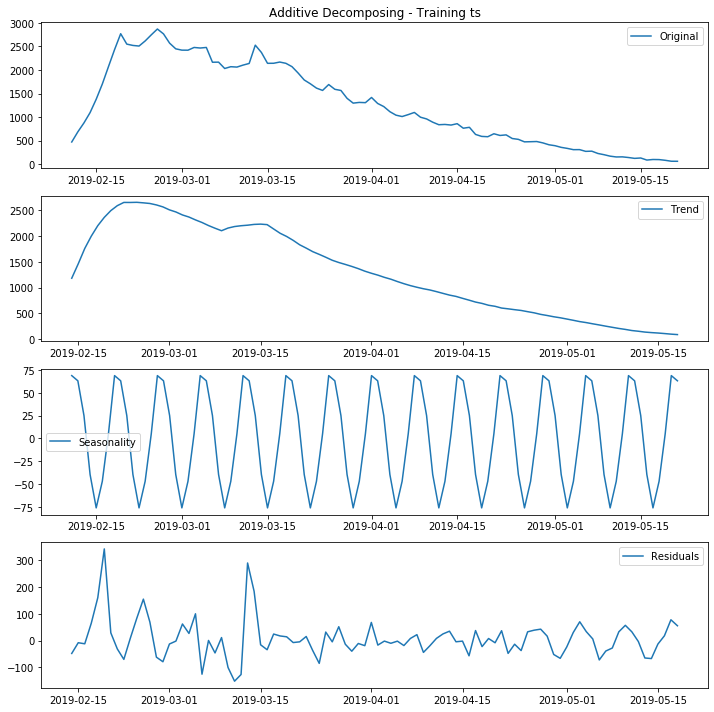

In [65]:
# Decompose trend, seasonality are separated out from data
decomposition = seasonal_decompose(sample_train_df['client_count'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(sample_train_df['client_count'], label='Original')
plt.title('Additive Decomposing - Training ts')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

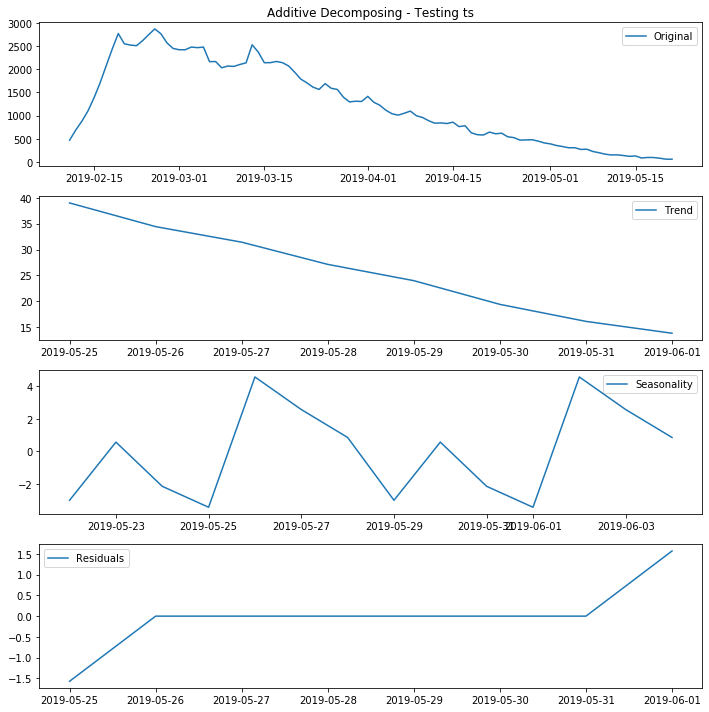

In [66]:
decomposition = seasonal_decompose(sample_test_df['client_count'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,10))
plt.subplot(411)
plt.plot(sample_train_df['client_count'], label='Original')
plt.title('Additive Decomposing - Testing ts')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()